# MCMC Double Slit Reconstruction
Le Nguyen

Reference: http://physics.mq.edu.au/~jcresser/Phys301/Chapters/Chapter4.pdf

For this project I would like to take an interference pattern form the double slit experiment and reconstruct the mass and velocity of the particle that was used. In order to do this I'm using markov chain monte carlo to reconstruct with the fitting parameters. The markov chain starts with a random guess for both velocity and mass, then uses the theoretical model, and finally comparees it's findings to real data to find an optimal fit using the metropolis-hastings algorithm. 

To run the code, simply go up to "kernel" at the top and then select "restart and run all".


# Remarks

Python is the coding language I am most experianced with, so that's why I did my project in it. The problem is python is a sub-optimal language for what I'm trying to do, and as a result, I had to take a few liberties in the code for the sake of computational speed (and not melting my MacBook). I'll identify where these liberties are taken throughout the notebook (they are mostly taken to start the markov chain in a place where it will actually converage in a reasonable amount of time). 

# The Set Up

To set up my project, I generated an interference pattern with the theoretical model of the double slit experiment. I did this with taking the theoretical distribution, and rolling a random number against it. If the random number was greater than the probability given in theory, the point was accepted. This was done to determine the x position of the particle, the y position of the particle is just another random number to give the interferance pattern a verticle spread. 

This simulated interferance pattern is being used as the real/experimental data to do fit. This has the advantage that I know what the correct answer is, becasue I generated the data. This makes error analysis easier, and since I'm using the same model that generated data, to fit the data, I'm really testing how well the monte carlo fitting method works. I already know it's using the correct model to fit, but how well can it fit it?

In [1]:
#importing needed libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci
%matplotlib inline

In [2]:
def double_slit(a,d,lamb,l,x):
    
    #Calculating some constants
    c = (np.pi*d)/(lamb*l)
    k = (np.pi*a)/(lamb*l)
    
    #Probability function
    f = ((np.cos(c))**2)*(((np.sin(k*x))/(k*x))**2)
    
    return f


def montecarlo(a,d,lamb,l):
    
    #Monte carlo throw for a particle
    x = np.random.uniform(-10.,10.)
    
    f = double_slit(a,d,lamb,l,x)
    rand = np.random.uniform(0,1)
    
    if (rand <= f):
        return x

"""The parameters of the system given below make an aesthetically pleasing interferance pattern, there isn't
any more reasoning than that, feel free to change them"""

#Parameters of our system
m= 5 #Mass
v= 10 #velocity                     

lamb= 1./(m*v) #"de broglie wavelength", scaled to be used in this modeled, h = 1. 
a = .1 #Slit width
d = 10 #Distance between slits
l = 10 #Distance to screen

#Keeping track of the real mass and velocity
truth = [m,v]

#The loop that runs the monte carlo to generate the interferance pattern
particles = []
for i in range(100000):
    y = np.random.uniform(0,1)
    
    x = montecarlo(a,d,lamb,l)
    if x != None:
        particles.append([x,y])
    

Number of particles: 9989


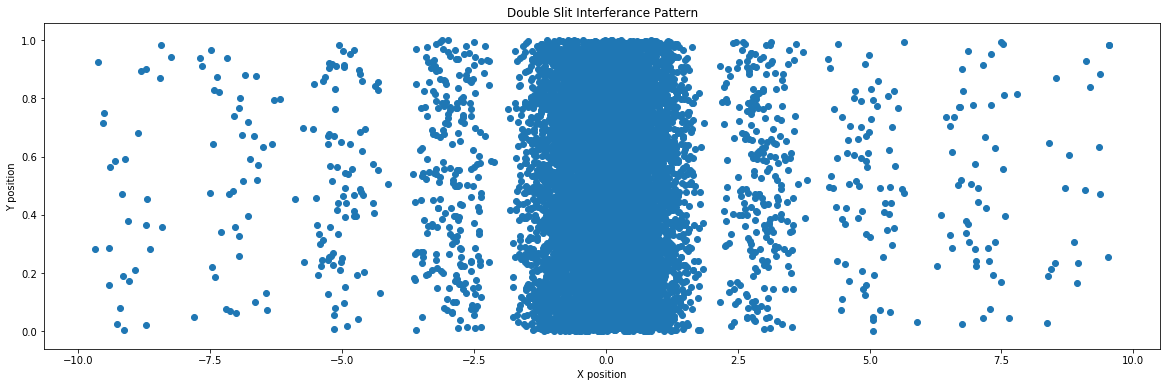

<Figure size 864x432 with 0 Axes>

In [3]:
#Visualize of the interferance pattern 
print("Number of particles:", len(particles))
particles = np.array(particles)
plt.figure(figsize = (20,6))
plt.scatter(particles[:,0],particles[:,1])
plt.title("Double Slit Interferance Pattern")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.show() 

plt.figure(figsize = (12,6))

plt.tight_layout()
plt.show()

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


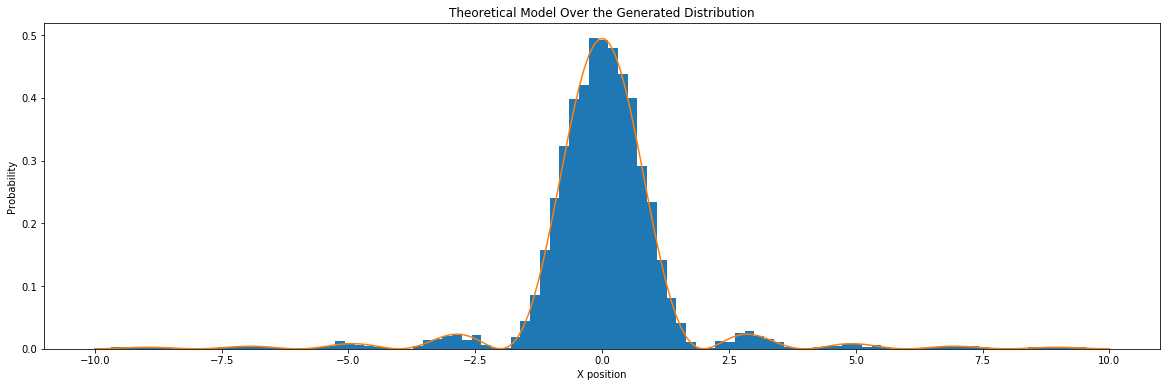

In [4]:
#Showing that the generated model fits the theoretical model.
plt.figure(figsize = (20,6))
y,x,_ = plt.hist(particles[:,0], normed = True, bins = 100)
p = y
p = np.array(p)

x = np.linspace(-10,10,200)

plt.plot(x,max(p)*double_slit(a,d,lamb,l,x)) #max(p) is there to normalize the function.
plt.title("Theoretical Model Over the Generated Distribution")
plt.ylabel("Probability")
plt.xlabel("X position")
plt.show()

# The MCMC

Below is the markov chain used to fit the mass and velocity parameters. It starts with a random guess for both, but this is were I had to take some liberties with the code. I bounded the random guess to be farily close to the correct answer, so the markov chain could converge with a reasonable amount of steps. The mass guess is bounded between (0,5), and the velocity is bounded between (mass guess,10)- the velocity is always guessed as a higher number than the mass. 

Also, I found a problem with fitting to my model since it is dependent on sine and cosine. Since both functions are periodic, multiple values will get the same output. This became a problem with the MCMC fitting because it would find the set of parameters that were "correct" but shifted by a period. This is another reason I bounded my initial guess.

I kept the other parameters of the system constant. Things like the distance to the screen, the slit spacing, and slit width are things we could know, but it would be easy enough to modify the markov chain to try to fit these as well. It might just take a long time. 

In [5]:
#We know the model we're using to generate, but need to adjust it to take mass and velocity
def double_slit2(m,v,a,d,l,x):
    
    #Calculating some constants
    c = (np.pi*d)/((1/(m*v))*l)
    k = (np.pi*a)/((1/(m*v))*l)
    
    #Probability function
    f = ((np.cos(c))**2)*(((np.sin(k*x))/(k*x))**2)
    
    return f

#Error calculation used to roll the probablity of updating the parameters
def calculate_error(actual, model, sigma):
    
    return ((actual-model)**2/(2*sigma**2)).sum()/(actual.size)

#Used to find the highest count parameter out of the MCMC output
def find_fit(x,y):
    for i in range(len(y)):
        if y[i] == max(y):
            j = i

    fit.append(x[j+1])


In [6]:
"""Just a random seed I set, so you can see the exact numbers used when I made this project,
   feel free to change it."""
np.random.seed(12345678) 

#Starting with a random guess, but bonding the numbers for the sake of computational time. 
m_guess = np.random.uniform(1,5)
v_guess = np.random.uniform(m_guess,10)

params = [[m_guess], [v_guess]]

temp_params = []

# Setting up statistical parameters
sigma = .001 #The tolerance to accept/reject a set of parameters.
num_sample_points = 100000
step_size = .1

x = np.linspace(-10, 10, num_sample_points)

# Loop runs Markov Chain
for i in range(0,num_sample_points,1):
    
    #Step size decreases as the Markove Chain runs to hone in on a more percise value. 
    if i == int(num_sample_points *.3):
        step_size *=.1
    elif i == int(num_sample_points * .5):
        step_size *= .1
        
    #Randomly steps temporary values
    for j in range(0,2):
        rand = np.random.uniform(-1,1)
        if i == 0:
            temp_params.append([params[j][i] + rand * step_size])
        else:
            temp_params[j].append(params[j][i] + rand * step_size)

    # Plugs starting and randomly varied temporary values into the theoretical function
    f1 = double_slit2(params[0][i], params[1][i], a, d, l, x[i])
    f2 = double_slit2(temp_params[0][i], temp_params[1][i], a, d, l, x[i])

    # Calculates error
    X1 = calculate_error(p, max(p)*f1, sigma)
    X2 = calculate_error(p, max(p)*f2, sigma)

    # Calculated probability the parameters change
    prob = np.exp(-(X2 - X1))
    rand2 = np.random.uniform(0,1)

# Updates parameters if the random number above is less than the probability
    if rand2 < prob:
        for k in range(0, 2):
            params[k].append(temp_params[k][i])  
    else:
        for k in range(0, 2):
            params[k].append(params[k][i])

    if i % (num_sample_points / 10) == 0:
        print(('%d Percent') % (i / num_sample_points * 100))

print('Finished')

0 Percent
10 Percent
20 Percent
30 Percent
40 Percent
50 Percent
60 Percent
70 Percent
80 Percent
90 Percent
Finished


# The Analysis

The first set of plots in my analysis are a 2d histogram of the fitting parameters and a corresponding contour map. This shows the expected behavior of the MCMC as it randomly steps around and searches for values that get a lower and lower error. As we can see, the MCMC varies wildly at first, finding various local minimums of error, then stepping out of them to try to find the global minimum. Each time the step size is reduced throughout the run, the varations get smaller. Finally, the MCMC starts to converge at a set of values and stays around that space. Each step it takes is in the same relative area getting higher and higher counts for that set of values, making them the most probable in the chain. 

The countour map shows that the area of convergance is small. If the MCMC takes even a small step around the area, it will find less probable parameters and most likely reject the step. This is unfortunate, because this caused the MCMC to stop exploring more space. Even though this area lowers the error the most out of the area the MCMC has explored, it could still be a local minimum, just the lowest minimum it has seen.  


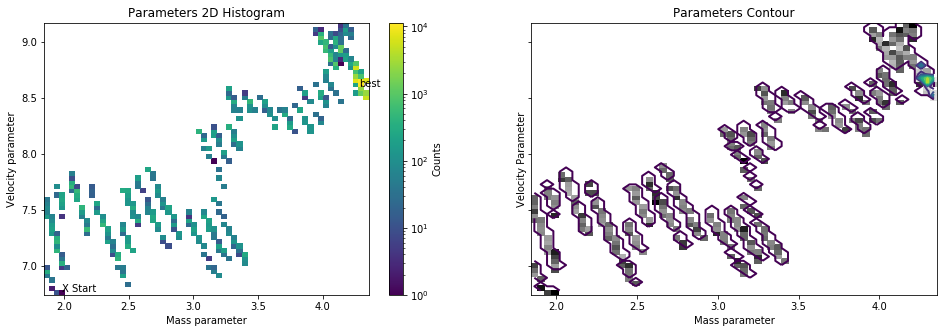

In [7]:
from matplotlib.colors import LogNorm

fig, [colored, bw] = plt.subplots(1,2, sharey=True, figsize = (16, 5))

counts, xbin, ybin, img = colored.hist2d(params[0], params[1], bins=64, norm=LogNorm())
colored.annotate('X Start', xy=(params[0][0], params[1][0]))

# use np.argwhere() to find the bin(s) with the max counts
max_location = np.argwhere(counts == counts.max())

# Use the location of the max to find the best width and intercept parameters
best_mass = xbin[max_location[0,0]]
best_velocity = ybin[max_location[0,1]]
colored.annotate('best', xy=(best_mass, best_velocity))

bw.hist2d(params[0], params[1], bins=60, norm=LogNorm(), cmap='gray')
bw.contour(0.5*(xbin[1:]+xbin[:-1]), 0.5*(ybin[1:]+ybin[1:]), counts.transpose(), linewidths=2)

colored.set_xlabel("Mass parameter")
colored.set_ylabel("Velocity parameter")
colored.set_title("Parameters 2D Histogram")
fig.colorbar(img, ax = colored, label = "Counts")

bw.set_xlabel("Mass parameter")
bw.set_ylabel("Velocity Parameter")
bw.set_title("Parameters Contour")
plt.show()

The next two plots are the 1d histograms of the mass and velocity parameter. This makes it easier to see how each parameter was explored. The 1d histograms further show how the MCMC ran into a narrow area of convergence that was also a local minumum in error. It got to this local minimum and got stuck, espeically with the mass parameter, but we can see that the velocity parameter started to step out of the local minimum and explore more.

We can see that it did make its way from the starting guess towards the true values, it got close, but it also got stuck.

Guess Mass: 1.9832169352996103 , Guess velocity: 6.764655677743697
True Mass: 5 , True velocity: 10
MCMC Fit Mass: 4.35611126090431 , MCMC Fit Velocity: 8.680666277037176


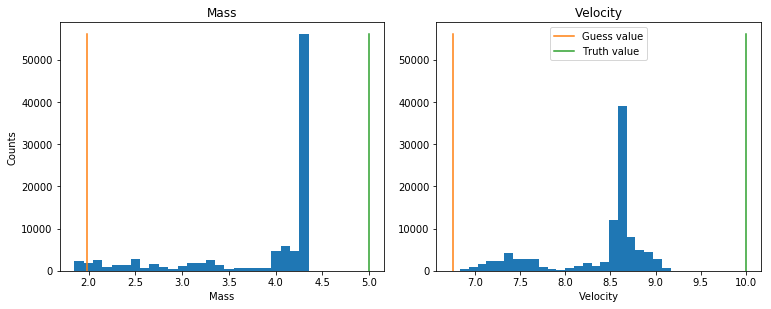

In [8]:
#Looking at the MCMC output
plt.figure(figsize = (16,8))
fit = []

plt.subplot(2,3,1)
y1, x1,_ = plt.hist(params[0], bins = 25)
plt.plot([params[0][0],params[0][0]],[0,y1.max()], label = "Seed value")
plt.plot([m,m],[0,y1.max()], label = "Truth value")
plt.title("Mass")
plt.xlabel("Mass")
plt.ylabel("Counts")
find_fit(x1,y1)

plt.subplot(2,3,2)
y2, x2,_ = plt.hist(params[1], bins = 25)
plt.plot([params[1][0],params[1][0]],[0,y1.max()], label = "Guess value")
plt.plot([v,v],[0,y1.max()], label = "Truth value")
plt.title("Velocity")
plt.xlabel("Velocity")
find_fit(x2,y2)

plt.legend()

plt.tight_layout()
print("Guess Mass:", m_guess,",", "Guess velocity:", v_guess)
print("True Mass:", truth[0],",", "True velocity:", truth[1])
print("MCMC Fit Mass:", fit[0],",", "MCMC Fit Velocity:", fit[1])
plt.show()

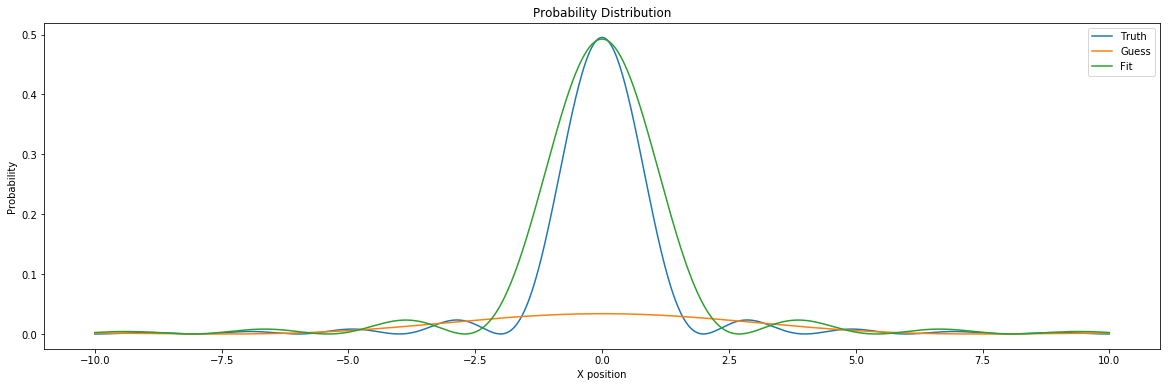

In [9]:
#Plotting the theoretical function with various sets of mass and velocity parameters
plt.figure(figsize = (20,6))
plt.plot(x,max(p)*double_slit(a,d,lamb,l,x),label = "Truth")
plt.plot(x,max(p)*double_slit2(params[0][0],params[1][0],a,d,l,x), label = "Guess")
plt.plot(x,max(p)*double_slit2(params[0][-1],params[1][-1],a,d,l,x), label = "Fit")
plt.title("Probability Distribution")
plt.ylabel("Probability")
plt.xlabel("X position")

plt.legend()
plt.show()

The last two plots show the relative error vs. the number of steps and follows the behavior in the previous charts. The error starts out high as expected. Dipping and rising as the MCMC finds local minimums, and steps out of them. The variation starts to reduce as the steps get finer and finer, then the error levels off when the chain finds a spot to converge. Unfortuantely, this spot is a local minimum, so the error is unlikely to get any lower after the level off, unless the chain can manage to step out of it.

Note: When you run this notebook, the tail end of the error may vary because of the inherent randomness of the reconstruction. It always follows the behavior described above, but sometimes we can see the chain start to step out of the local minimum. This looks like the error rising as the chain starts to explore the region of less probable parameters, and then possibly lowering again once it starts to find another minimum.  

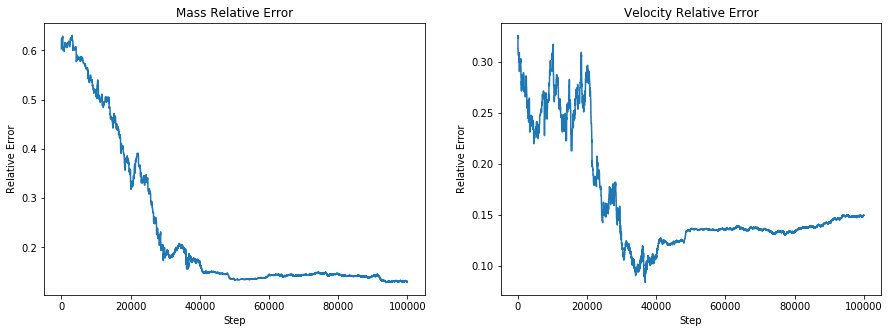

<Figure size 432x288 with 0 Axes>

In [10]:
m_error = abs(np.array(params[0])-m)/m
v_error = abs(np.array(params[1])-v)/v

plt.figure(figsize = (15,5))

t = np.linspace(0,len(m_error),len(m_error))
plt.subplot(1,2,1)
plt.plot(t,m_error)
plt.title("Mass Relative Error")
plt.xlabel("Step")
plt.ylabel("Relative Error")

plt.subplot(1,2,2)
plt.plot(t,v_error)
plt.title("Velocity Relative Error")
plt.xlabel("Step")
plt.ylabel("Relative Error")

plt.show()
plt.tight_layout()